In [ ]:
# import tensorflow as tf

In [ ]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

In [ ]:
# os.chdir("/mnt/")
import neuraluq.neuraluq as neuq
import neuraluq.neuraluq.variables as neuq_vars
from neuraluq.neuraluq.config import tf

import numpy as np
import scipy.io as sio
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [ ]:
!git clone https://github.com/Annaantonin/Data.git

In [ ]:
rm -rf Data

In [ ]:
!git clone https://github.com/Crunch-UQ4MI/neuraluq.git

In [ ]:
import Data as data
# data = sio.loadmat("Data/sdof_2000.mat")

In [ ]:
!git clone https://github.com/Crunch-UQ4MI/neuraluq.git
#!git clone https://github.com/Annaantonin/Data.git
!pip install tensorflow-probability
!pip install scipy
import os
# os.chdir("/tf/neuraluq/")
!python setup.py install

In [ ]:
os.listdir(".")

In [86]:
# -*- coding: utf-8 -*-
"""
Created on Wed Oct  4 16:14:30 2023

@author: Antonina
"""

#%%
# Simulated SDOF with:
#K_true=10;
# C_true=0.2236; %system damping ratio 5%

# m=5; %mass for sdof example

def load_data(noise):

    #data = sio.loadmat(r"G:\My Drive\Python_codes\NNs\sdof_ymeas.mat")
    data = sio.loadmat("Data/sdof_noforce.mat")
    #  t_x_train, t_f_train = data["t"], data["ymeas"]
    # data = matdata['data']
    x_tt_train, t_train = data["a"], data["t"]
    x_train, f_train = data["u"], data["force"]
    # Input_train=t, x_tt
    # train_x_tt = t_x_tt_train, x_train
    # train_f = t_f_train, f_train

    return  x_tt_train, t_train.T, x_train, f_train.T

#m=1
# [0][..., 0:1]     

def pde_fn(t, x, c, k):
    m=5
    # log_k=tf.clip_by_value(log_k,np.log(0),np.log(20)) # to make constrains for the parameters
    # log_c=tf.clip_by_value(log_c,np.log(0),np.log(0.5))
    x_t = tf.gradients(x, t)         #velocity                                                                                                                                                                                                                   
    x_tt = tf.gradients(x_t, t)

    f = m*x_tt+c*x_t+k*x
    # f - tf.multiply(x_tt, 5.0)+ tf.exp(log_c) * x_t + tf.exp(log_k) * x
    # return [f,x_tt]
    return f

def pde_xtt(t,x):
    x_t = tf.gradients(x, t)                                                                                                                                                                                                                        
    x_tt = tf.gradients(x_t, t)
    
    return x_tt
    
@neuq.utils.timer
def Trainable(
   x_tt_train, t_train, x_train, f_train, noise, layers, 
):
    # build processes
    
    process_x = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers),
        # surrogate=neuq.surrogates.FNN(layers=layers,activation=RELu),
        posterior=neuq_vars.fnn.Trainable(layers=layers),# displacement
    # )
         # posterior=neuq_vars.fnn.Trainable(
         #    layers=layers, regularizer=tf.keras.regularizers.l2(1e-5)
        # ),
    )
    process_log_c = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        posterior=neuq_vars.const.Trainable(value=0),
    )
    process_log_k = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        posterior=neuq_vars.const.Trainable(value=0),
    )
    method = neuq.inferences.DEns(
        num_samples=1, num_iterations=3000, optimizer=tf.train.AdamOptimizer(1e-3),
    )

    # build losses
    loss_x = neuq.likelihoods.MSE(
        inputs=t_train,
        targets=x_tt_train, # could be the problem
        processes=[process_x],
        pde=pde_xtt, # dotdot _X
        multiplier=1,
    )
    
    loss_f = neuq.likelihoods.MSE(
        inputs=t_train,
        targets=f_train, # minimizing the loss to be close to zero
         # targets=np.zeros_like(t_train), # minimizing the loss to be close to zero
        processes=[process_x, process_log_c, process_log_k], # tf train
        pde=pde_fn,
        multiplier=1,
    )
    # build model
    model = neuq.models.Model(
        processes=[process_x, process_log_c, process_log_k],
        likelihoods=[loss_x, loss_f],
    )
    # assign and compile method
    model.compile(method)
    # obtain posterior samples
    samples = model.run()
    # samples,results = model.run()
    # print("Acceptance rate: %.3f \n" % (np.mean(results)))
    
    processes = [process_x, process_log_c, process_log_k]
    return processes, samples, model


if __name__ == "__main__":

    noise = 0

    x_tt_train, t_train, x_train, f_train = load_data(noise)

    # t_x_tt_train, x_tt_train = train_x_tt
    # t_f_train, f_train = train_f

    layers = [1,50,50,1]

    processes, samples, model = Trainable( x_tt_train, t_train, x_train, f_train, noise, layers,    )

    x_pred, c_pred, k_pred = model.predict(t_train, samples, processes, pde_fn=None)
    (f_pred,) = model.predict(t_train, samples, processes, pde_fn=pde_fn)

Supporting backend tensorflow.compat.v1

Compiling a Ensemble method

Generating 0th sample by deep ensemble...
Iteration:  0 , loss:  15.970745
Iteration:  1000 , loss:  1.3253639
Iteration:  2000 , loss:  0.64945763
Execution time for 'Trainable' function is: 82.823 s, 1.380 mins


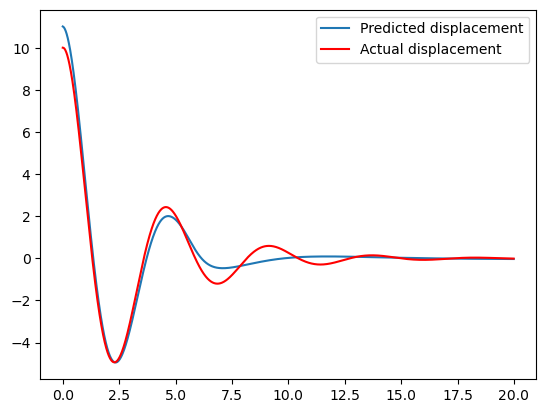

In [87]:
# [a.shape for a in samples]
plt.plot(t_train,np.mean(x_pred,axis=(0, 2)),label='Predicted displacement')
plt.plot(t_train,x_train,'r',label='Actual displacement')
plt.legend()

In [ ]:
# plt.plot(x_pred.flatten())

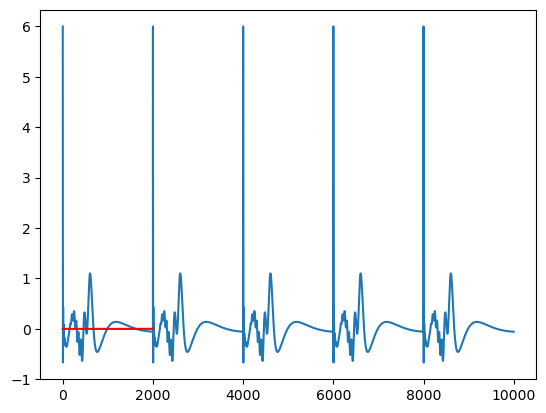

In [88]:
plt.plot(f_pred.flatten())
plt.plot(f_train,'r')

In [ ]:
# x_pred, logc_pred, logk_pred = model.predict(t_train, samples, processes, pde_fn=None)
# x_pred, logc_pred, logk_pred = model.predict(t_train, samples, processes, pde_fn=pde_fn)

In [84]:
np.hist(k_pred).flatten(), name="value of $k$")
np.hist(c_pred).flatten(), name="value of $c$")

SyntaxError: cannot assign to function call (948769068.py, line 1)

In [89]:
Csamp=samples[6]    
Ksamp=samples[7]
C_post=np.mean(Csamp)
print("C_true=0.22(Ns/m) and C_post =", C_post) 
K_post=np.mean(Ksamp)
print("K_true=10(N/m) and K_post =", K_post) 

C_true=0.22(Ns/m) and C_post = 0.6859985
K_true=10(N/m) and K_post = 1.8544949


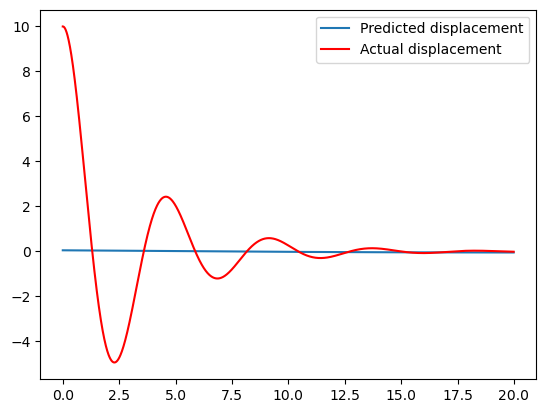

In [80]:
plt.plot(t_train,np.mean(x_pred,axis=(0, 2)),label='Predicted displacement')
plt.plot(t_train,x_train,'r',label='Actual displacement')
plt.legend()

In [ ]:
# sio.savemat("G:/My Drive/Python_codes/sdof0.mat", {"x_pred":x_pred, "k":samples[7].flatten(),"c":samples[6].flatten()})

In [ ]:
# data_to_save = {
#    "x_pred":x_pred, "c":samples[6].flatten(),"k":samples[7].flatten()
# }
# file_name = 'output.mat'
# sio.savemat(file_name, data_to_save)

x_tt_train, t_train, x_train, f_train = load_data(noise, noise)
plt.plot(x_train)

In [ ]:
Input_train=np.vstack((t_train,x_tt_train))
plt.plot(Input_train)       

In [ ]:
 t, x_tt=np.split(Input_train, 2)
plt.plot(x_tt)

In [ ]:
inputs=np.concatenate([t_train, x_tt_train], axis=-1)


In [ ]:
plt.plot(inputs)